# CISCO FORUM COMMENT CLASSIFICATION

#### LOADING DEPENDENCIES

In [1]:
import nltk
from collections import Counter
import math
import pickle
from collections import OrderedDict
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string

In [2]:
stopword_file = open("terrier-stop.txt","r")
t_stop = stopword_file.read().splitlines()

#### LOADING COMMENTS

In [62]:
acronyms_file = open("acronyms.txt","r")
acronyms = acronyms_file.read().splitlines()
print(len(acronyms))

1060


In [63]:
data = pickle.load( open( "comments", "rb" ) ,encoding='latin1')
comments = data['comments']

In [8]:
documents = []
for comment in comments:
    str_comment  = ''
    for sentence in comment:
        str_comment += sentence  
    documents.append(str_comment)

In [9]:
documents[1]

'Hello,I will try to build a small LAB for my studies (including CCNA and CCNP certification) but I am surrounded by 2 questions.1-Is this equipment sufficient for a LAB in order to pass certifications CCNA and CCNP ?2-Can I use a etherswitch (NM-16ESW) as a normal switch to link it at computer, D-Link Switch etc...If not, what type of modul I need to use ?Otherwise, can I also use it as a WAN socket like the 2 sockets already here in the Cisco router 1821 ?My existing equipments :-D-Link Switch DGS-1216T 16 port 10/100/1000 (actually in use, but full)-My PC (for test ^^)-A Server with 6 Ethernet sockets (for VMs with VMware, 16 core 72Go RAM)-My Bouygue router (given by my FAI, in french)-A 4G router of Huawei (better than my adsl ^^)The equipments that I want to buy to try it and for my studies :-Cisco router 2821 -Cisco router 1821 -Cisco Switch WS-C2960G-24TC-L (24 ports 10/100/1000 to replace my D-link)Sincerely Thomas'

#### COMMENT PRE - PROCESSING

In [10]:
def comment_cleaner(comment):
    
    words = nltk.word_tokenize(comment)
    words = [word.lower() for word in words if word.isalpha()]
    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words]
    words = [word for word in words if word.isalpha()]
    
    word_tags = nltk.pos_tag(words)
    
    words = [word for word,tag in word_tags if tag in ('NN','JJ','NNP','NNS','NNPS')]
    #words.extend([word[-1] for word,tag in word_tags if tag in ('NNS','NNPS')])
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    words = [word for word in words if not word in t_stop]
    # stemming of words
    #lemma = nltk.stem.wordnet.WordNetLemmatizer()
    #words = [lemma.lemmatize(word) for word in words]
        
    #porter = PorterStemmer()
    #words = [porter.stem(word) for word in words]
    cleaned_comment = ' '.join(words)
    
    return cleaned_comment

In [12]:
comment_cleaner(documents[1])

'lab studies ccna ccnp certification equipment sufficient lab order certifications ccna ccnp etherswitch normal switch computer switch type modul wan socket sockets router equipments port pc test server ethernet sockets vms vmware core ram bouygue router fai french router huawei adsl equipments studies router switch ports'

In [64]:
cleaned_comments = []

for i in range(len(documents)):
    cleaned_comments.append(comment_cleaner(documents[i]))

In [14]:
len(cleaned_comments)

351

In [65]:
all_comments = " ".join(cleaned_comments)
all_words = all_comments.split()
len(all_words)

36755

#### FINDING THE MOST FREQUENT WORDS IN CORPUS


In [52]:
most_common = Counter(all_words).most_common(50)[1:]
print(most_common)

[('ip', 811), ('interface', 524), ('command', 493), ('address', 453), ('cli', 397), ('switch', 360), ('vlan', 335), ('router', 303), ('network', 257), ('port', 228), ('config', 197), ('mode', 177), ('configuration', 176), ('event', 164), ('dhcp', 156), ('traffic', 147), ('host', 140), ('server', 138), ('switchport', 133), ('permit', 129), ('output', 123), ('route', 123), ('match', 116), ('script', 113), ('version', 113), ('manager', 113), ('link', 112), ('debug', 111), ('device', 106), ('applet', 103), ('switches', 102), ('ios', 99), ('policy', 93), ('ports', 93), ('problem', 92), ('crypto', 90), ('trunk', 87), ('description', 86), ('nat', 86), ('type', 84), ('feb', 83), ('group', 83), ('tunnel', 80), ('site', 78), ('prefix', 76), ('auto', 75), ('software', 74), ('mac', 73), ('static', 70)]


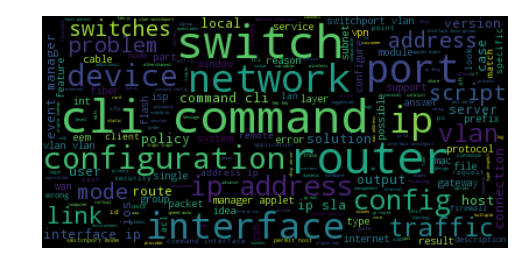

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
stopwords_w = set(STOPWORDS)


wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords_w,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(all_comments)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### CREATING WORD EMBEDDING TO FIND SIMILAR WORDS



In [19]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Word2Vec
sentences = [cleaned_comment.split() for cleaned_comment in cleaned_comments]
model = Word2Vec(sentences,min_count = 1)

In [20]:
print(model)
words = list(model.wv.vocab)
len(words)

Word2Vec(vocab=4684, size=100, alpha=0.025)


4684

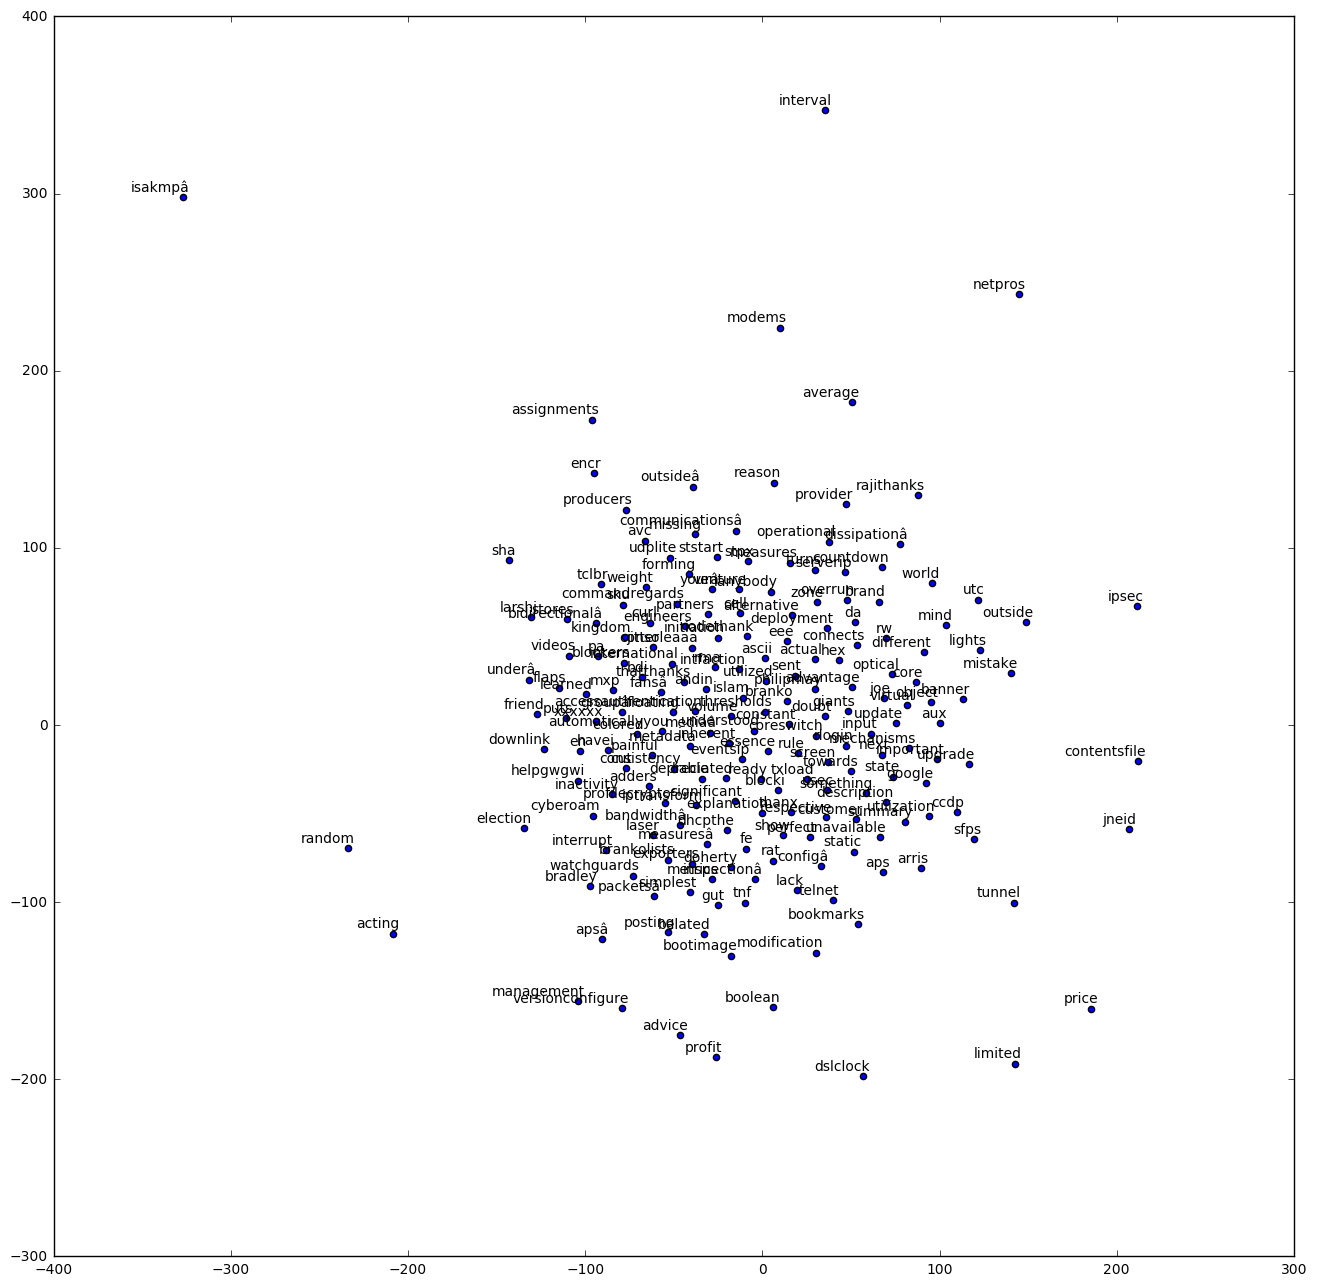

In [35]:
from sklearn.manifold import TSNE
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in words[:200]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
    
tsne_plot(model)

In [21]:
model.most_similar("vlan",topn=5)

[('shutdown', 0.9994842410087585),
 ('debug', 0.9993783831596375),
 ('nat', 0.9992038011550903),
 ('applet', 0.9991813898086548),
 ('gigabitethernet', 0.9990278482437134)]

#### FINDING SET OF SIMILAR WORDS TO MOST FREQUENT WORDS FOR COMMENT CLASSIFICATION

In [22]:
most_similar = dict()
for i in range(len(most_common)):
    
    sim_words = model.most_similar(most_common[i][0],topn=9)
    
    most_similar[most_common[i][0]] = [word for word,_ in sim_words]

In [23]:
for key,_list in most_similar.items():
    print("\t"+key + "\t:\t"+str(_list))

	prefix	:	['switch', 'interfaces', 'lan', 'acl', 'user', 'security', 'traffic', 'asa', 'servers']
	network	:	['switches', 'problem', 'service', 'global', 'routers', 'solution', 'idea', 'devices', 'local']
	vlan	:	['shutdown', 'debug', 'nat', 'applet', 'gigabitethernet', 'dhcp', 'address', 'event', 'tunnel']
	configuration	:	['traffic', 'case', 'tcl', 'version', 'servers', 'setup', 'lan', 'pc', 'reason']
	crypto	:	['config', 'profile', 'isakmp', 'site', 'security', 'user', 'layer', 'vrf', 'dynamic']
	version	:	['configuration', 'traffic', 'tcl', 'case', 'interfaces', 'switch', 'lan', 'test', 'reason']
	switches	:	['network', 'problem', 'routers', 'power', 'solution', 'service', 'idea', 'commands', 'nexus']
	address	:	['nat', 'static', 'tcp', 'tunnel', 'pool', 'shutdown', 'route', 'gateway', 'destination']
	config	:	['policy', 'crypto', 'eem', 'ssh', 'variable', 'profile', 'environment', 'security', 'voice']
	mac	:	['license', 'next', 'internal', 'input', 'valid', 'login', 'fabric', 'mod

In [24]:
all_simwords = []
for key,_list in most_similar.items():
    all_simwords.extend(_list)

In [25]:
print(Counter(all_simwords))

Counter({'shutdown': 13, 'nat': 11, 'dhcp': 10, 'vlan': 8, 'debug': 8, 'route': 8, 'address': 8, 'pool': 7, 'event': 7, 'description': 7, 'applet': 7, 'static': 7, 'destination': 6, 'tunnel': 6, 'interface': 6, 'gigabitethernet': 6, 'gateway': 6, 'tcp': 5, 'accessâ': 5, 'routers': 5, 'profile': 5, 'idea': 5, 'security': 5, 'layer': 5, 'lan': 5, 'manager': 5, 'problem': 5, 'remote': 4, 'case': 4, 'traffic': 4, 'insideâ': 4, 'ddns': 4, 'sla': 4, 'vrf': 4, 'interfaces': 4, 'ip': 4, 'solution': 4, 'syslog': 4, 'ipsec': 4, 'user': 4, 'portfast': 4, 'version': 3, 'qos': 3, 'asa': 3, 'subnet': 3, 'permit': 3, 'voice': 3, 'commands': 3, 'cox': 3, 'connection': 3, 'switch': 3, 'source': 3, 'configuration': 3, 'isp': 3, 'error': 3, 'service': 3, 'switches': 3, 'cdp': 3, 'conf': 3, 'tcl': 3, 'vlans': 3, 'command': 3, 'devices': 3, 'policy': 3, 'routes': 3, 'ethernet': 2, 'sfp': 2, 'network': 2, 'part': 2, 'model': 2, 'mode': 2, 'switchport': 2, 'request': 2, 'file': 2, 'cable': 2, 'rip': 2, 'conf

In [26]:
comment_with_simwords = []
for i in range(len(cleaned_comments)):
    current_comment = cleaned_comments[i].split()
    current_comment = [word for word in current_comment if word in all_simwords]
    comment_with_simwords.append(current_comment)

In [27]:
comment_with_simwords[1]

['switch',
 'switch',
 'type',
 'wan',
 'router',
 'port',
 'pc',
 'test',
 'server',
 'ethernet',
 'router',
 'router',
 'router',
 'switch',
 'ports']

In [28]:
cleaned_comments[1]

'lab studies ccna ccnp certification equipment sufficient lab order certifications ccna ccnp etherswitch normal switch computer switch type modul wan socket sockets router equipments port pc test server ethernet sockets vms vmware core ram bouygue router fai french router huawei adsl equipments studies router switch ports'

In [29]:
len(nltk.corpus.stopwords.words('english'))

179

### IMPORTANT WORDS ANALYSIS USING TF-IDF SCORES

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_train = tfidf_vectorizer.fit_transform(cleaned_comments)

In [31]:
def get_impwords(doc,no_words = 15 ,get_score = True):
    feature_names = tfidf_vectorizer.get_feature_names()
    
    feature_index = tfidf_matrix_train[doc,:].nonzero()[1]
    tfidf = []
    for x in feature_index:
        pair = (tfidf_matrix_train[doc, x],feature_names[x])
        tfidf.append(pair)
    tfidf.sort(reverse = True)
    
    if get_score:
        return tfidf[:no_words]
    else:
        return [x[1] for x in tfidf[:no_words]]

To find the most important words within a comment pick the words with high tfidf scores

In [32]:
get_impwords(doc = 1,no_words = 15,get_score = False)

['studies',
 'equipments',
 'sockets',
 'ccnp',
 'ccna',
 'router',
 'lab',
 'switch',
 'vms',
 'modul',
 'huawei',
 'french',
 'fai',
 'bouygue',
 'adsl']

In [33]:
all_impwords = []
for i in range(len(cleaned_comments)):
    all_impwords.extend(get_impwords(doc = i,no_words = 15,get_score = False))

In [34]:
print("total number of important words "+str(len(all_impwords)))
print("total number of unique words " + str(len(set(all_impwords))))

total number of important words 4821
total number of unique words 2389


#### FINDING TECH CLASSES
To find the tech classes take the most frequently occuring imp words from each input comment

In [35]:
class_freq = Counter(all_impwords).most_common(15)
classes = [pair[0] for pair in class_freq]
print(classes)


['ip', 'router', 'interface', 'address', 'switch', 'vlan', 'command', 'network', 'cli', 'port', 'server', 'traffic', 'config', 'dhcp', 'event']


##### Number of classes Vs comment percentage plot
This plot helps us choose the number classes avoiding over - classification

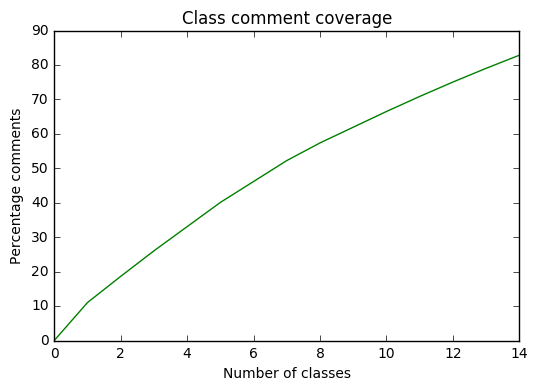

In [36]:
# total_comments multiplied by the factor to compensate class overlapping
total_comments = 1.5*len(cleaned_comments) 
comment_percentage = [0]
num_classes = [0]
for i in range(1,15):
    comment_percentage.append(class_freq[i-1][1] + comment_percentage[i-1])
    num_classes.append(i)

comment_percentage  = [y*100/total_comments for y in comment_percentage]

plt.plot( num_classes,comment_percentage, color='g')

plt.xlabel('Number of classes')
plt.ylabel('Percentage comments')
plt.title('Class comment coverage')
plt.show()

### Assigning Class labels to comments

In [66]:
class_label = []
for i in range(len(cleaned_comments)):
    impwords = get_impwords(doc = i,no_words = 15,get_score = False)
    flag = 0
    for word in impwords:
        if word in classes :
            class_label.append(word)
            flag = 1
            break
    if flag == 0:
        for word in impwords:
            if  word in acronyms:
                class_label.append(word)
                flag = 1
                break
        
    if flag == 0:
        class_label.append('UNK')
    

In [67]:
Counter(class_label).most_common(15)

[('UNK', 63),
 ('ip', 30),
 ('router', 22),
 ('switch', 19),
 ('cli', 18),
 ('network', 17),
 ('vlan', 17),
 ('port', 17),
 ('address', 16),
 ('config', 13),
 ('server', 12),
 ('traffic', 11),
 ('dhcp', 8),
 ('interface', 7),
 ('command', 6)]

### Retrieving Comment Info

In [68]:
def get_info(doc):
    
    print("\nOriginal Comment : \n\n"+documents[doc])
    print("\nProcessed Comment : \n\n"+cleaned_comments[doc])
    print("\nImportant words : \n\n"+str(get_impwords(doc = doc,no_words = 15,get_score = False)))
    print("\nClass Label : \t"+class_label[doc])
    

In [71]:
get_info(16)


Original Comment : 

We are currently evaluating CML 1.3 to see if it's viable for our Lab setup usage.We would like to set up a Lab environment in order to test upgrades.We were going to use CML to model our WAN environment and then use external servers to spin up models of our UC environment.That way we can test upgrades to UC offline prior to online upgrades.What we would like to do, though, is hang our UC Host servers off of the FLAT networks tied in via PCI NIC ports (one per FLAT).CML 1.3 requires the configuration of FLAT and FLAT1.I can configure and attach a FLAT2 in VMWare, but it's not showing on the CML server.Is what I am attempting even possible?Thanks,Jim

Processed Comment : 

cml viable lab setup lab environment order cml wan environment external servers models uc upgrades offline hang uc host servers flat networks pci nic ports flat configuration flat vmware cml possible jim

Important words : 

['flat', 'cml', 'uc', 'servers', 'lab', 'environment', 'viable', 'pci', 